# Self supervised learning on CIFAR100
### Group members


*   Ashutosh Chauhan (S20180010017)
*   Pradum Singh (S20180010136)
*   Vipul Rawat (S20180010192)
*   Ayush Gairola (S20180010020)

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
import torchvision.transforms as TF
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from tqdm.notebook import tqdm as tqdm
from random import randint

%matplotlib inline

In [2]:
# Run the model training on the GPU
device = torch.device("cuda:0")

In [4]:
# Transform the data to bring variance in dataset
transform = TF.ToTensor()

TrainingData = CIFAR100("./data", train=True, download=True, transform=transform)
ValidationData = CIFAR100("./data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


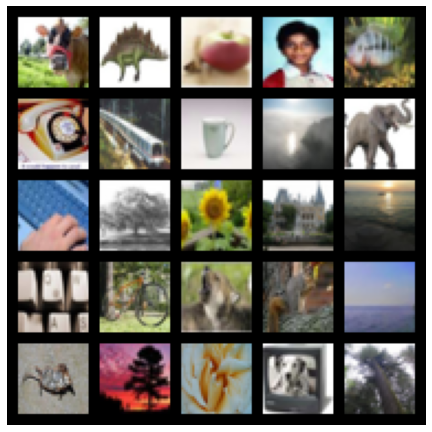

In [5]:
# The dataset
images = []
labels = []
for i in range(25):
  image, label = TrainingData[i]
  images.append(image)
  labels.append(label)

grid_image = make_grid(images, nrow=5, padding=5).permute(1, 2, 0)
grid_image = np.clip(grid_image.numpy(), 0 , 1)
plt.figure(figsize=(7.5, 15))
plt.axis("off")
plt.imshow(grid_image)

In [6]:
def initialize_parameters(model):

  def initialize_layer(layer):
    if isinstance(layer, nn.Conv2d):
      nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

    if isinstance(layer, nn.Linear):
      nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

  model.apply(initialize_layer)

In [7]:
def plot_show(epoch_loss, val_loss, val_acc):
  plt.figure(figsize=(10, 12))

  plt.subplot(2, 1, 1)
  plt.plot(epoch_loss, label="Training")
  plt.plot(val_loss, label="Validation")
  plt.title("Loss History")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(val_acc)
  plt.title("Accuracy History")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy %")

  plt.show()

In [8]:
def accuracy(predictions, actual):
  _, predictions = torch.max(predictions, dim=1)
  return torch.sum(predictions == actual).item() / len(predictions)

In [9]:
def fit(model, optimizer, train_loader, val_loader, epochs):
  EPOCH_LOSS = []
  VAL_LOSS = []
  VAL_ACC = []

  for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    nsteps = 0

    for batch in tqdm(train_loader):
      images, labels = batch
      images = images.to(device)
      labels = labels.to(device)
      nsteps += 1

      optimizer.zero_grad()
      output = model(images)
      loss = F.cross_entropy(output, labels)
      loss.backward()
      epoch_loss += loss.item()
      optimizer.step()

    EPOCH_LOSS.append(epoch_loss / nsteps)

    with torch.no_grad():
      model.eval()

      val_loss = 0
      val_acc = 0
      nsteps = 0

      for batch in val_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        nsteps += 1

        prediction = model(images)
        loss = F.cross_entropy(prediction, labels)
        acc = accuracy(prediction, labels)
        val_loss += loss.item()
        val_acc += acc
      
      VAL_LOSS.append(val_loss / nsteps)
      VAL_ACC.append(val_acc / nsteps * 100)

      model.train()
    
  return EPOCH_LOSS, VAL_LOSS, VAL_ACC

In [10]:
base_model = torchvision.models.resnet34(pretrained=False, progress=False)
base_model.fc = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 100))
initialize_parameters(base_model)

base_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

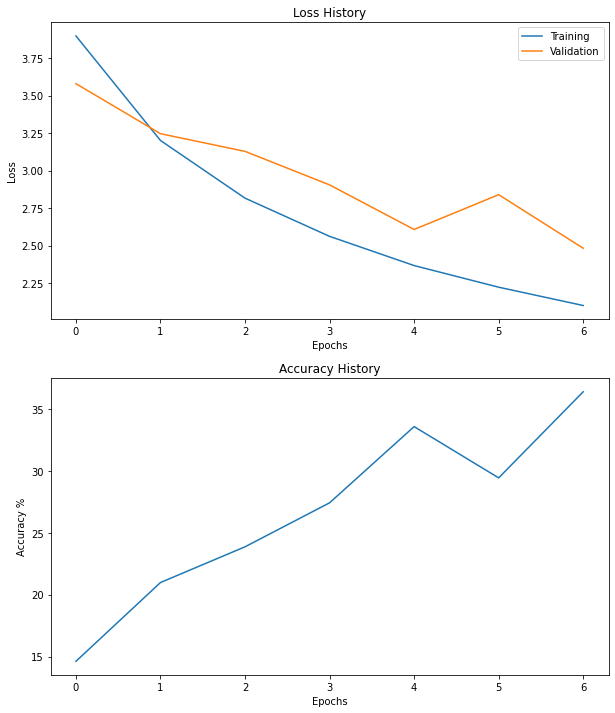

In [11]:
EPOCHS = 7
BATCH_SIZE = 125
LEARNING_RATE = 0.001
REGULARIZATION = 0.001

train_loader = DataLoader(TrainingData, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ValidationData, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(base_model.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)

simple_model_data = fit(base_model, optimizer, train_loader, val_loader, EPOCHS)

plot_show(*simple_model_data)

In [12]:
print("Accuracy of Base Model: ", simple_model_data[2][-1])

Accuracy of Base Model:  36.42999999999999


In [13]:
class RotationalTransform:
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, x):
        return TF.transforms.F.rotate(x, self.angle)

class VerticalFlip:
    def __init__(self):
        pass
    def __call__(self, x):
        return TF.transforms.F.vflip(x)

class HorizontalFlip:
    def __init__(self):
        pass
    def __call__(self, x):
        return TF.transforms.F.hflip(x)

In [14]:
class GenerateDataSet(Dataset):
    def __init__(self, data):
        self.data = data
        self.class_transforms = [RotationalTransform(0), 
                                 RotationalTransform(90), 
                                 RotationalTransform(180), 
                                 RotationalTransform(270), 
                                 HorizontalFlip(), 
                                 VerticalFlip()]
        self.images = []
        self.labels = []
        for img, _ in self.data:
          label = randint(0, len(self.class_transforms) - 1)
          self.images.append(self.class_transforms[label](img))
          self.labels.append(torch.tensor(label))

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

    def __len__(self):
        return len(self.images)

SupervisedTrainingData = GenerateDataSet(TrainingData)
SupervisedValidationData = GenerateDataSet(ValidationData)

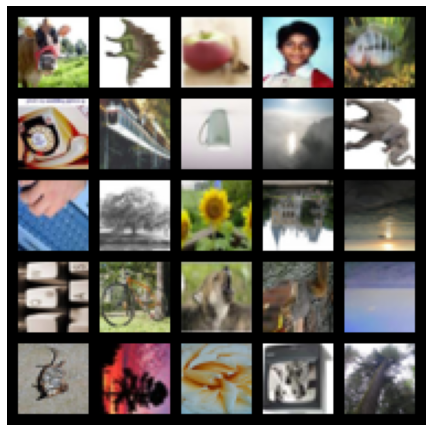

In [15]:
images = []
labels = []
for i in range(25):
  image, label = SupervisedTrainingData[i]
  images.append(image)
  labels.append(label)

grid_image = make_grid(images, nrow=5, padding=5).permute(1, 2, 0)
grid_image = np.clip(grid_image.numpy(), 0 , 1)
plt.figure(figsize=(7.5, 15))
plt.axis("off")
plt.imshow(grid_image)

In [16]:
supervised_model = torchvision.models.resnet34(pretrained=False, progress=False)
supervised_model.fc = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 6))

supervised_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

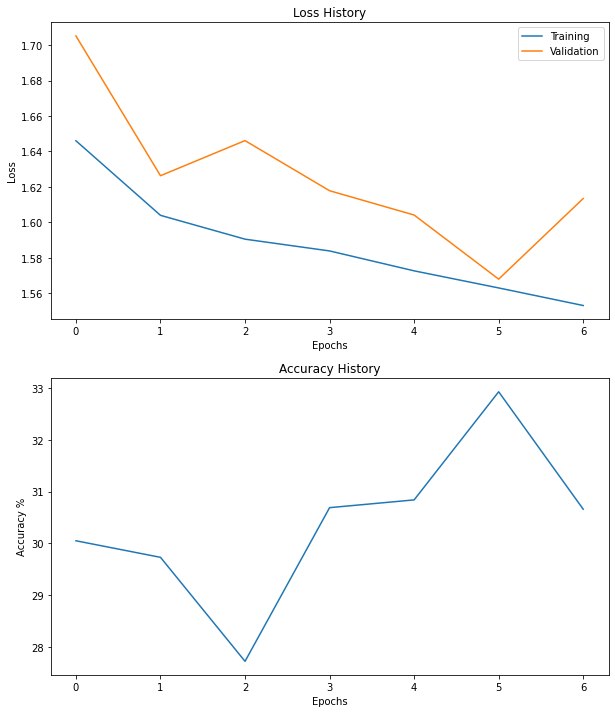

In [17]:
EPOCHS = 7
BATCH_SIZE = 125
LEARNING_RATE = 0.001
REGULARIZATION = 0.001

train_loader = DataLoader(SupervisedTrainingData, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(SupervisedValidationData, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(supervised_model.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)

supervised_model_data_pre = fit(supervised_model, optimizer, train_loader, val_loader, EPOCHS)

plot_show(*supervised_model_data_pre)

In [18]:
supervised_model.fc[2] = nn.Linear(256, 100).to(device)

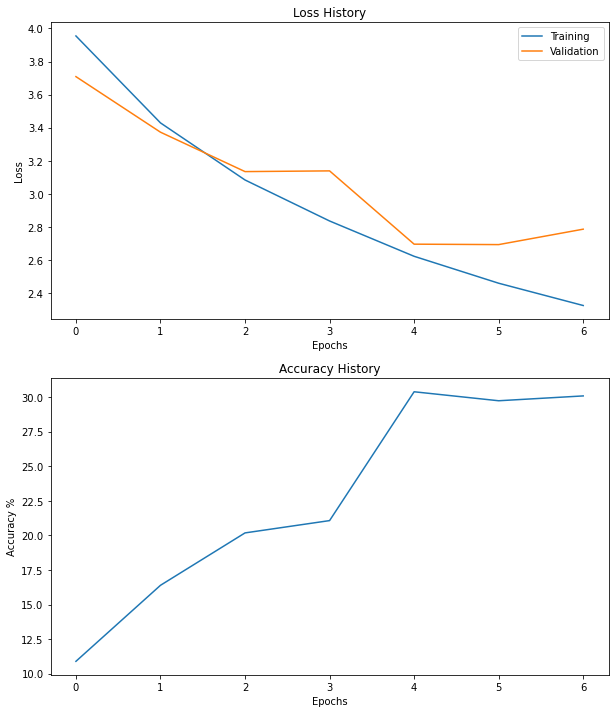

In [19]:
EPOCHS = 7
BATCH_SIZE = 125
LEARNING_RATE = 0.001
REGULARIZATION = 0.001

train_loader = DataLoader(TrainingData, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(ValidationData, batch_size=BATCH_SIZE)
optimizer = torch.optim.Adam(supervised_model.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)

supervised_model_data = fit(supervised_model, optimizer, train_loader, val_loader, EPOCHS)

plot_show(*supervised_model_data)

In [20]:
print("Accuracy of Supervised Model: ", supervised_model_data[2][-1])

Accuracy of Supervised Model:  30.08999999999999
